# Setup drive and folder

Per accedere alla cartella --> Tasto destro sulla cartella condivisa < Final Project > e aggiungere scorciatoia al MyDrive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/SL_Astro

/content/drive/MyDrive/SL_Astro


# Load dataset

In [3]:
from IPython.display import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from astropy.io import fits 
import numpy as np
import cv2
from astropy.visualization import make_lupton_rgb
import pickle
from tqdm import tqdm

In [4]:
def load_dataset(image_ds_path, mask_ds_path):
  with open(image_ds_path, 'rb') as handle:
    image_dataset = pickle.load(handle)
  image_dataset = image_dataset.reshape(-1, 256, 256)

  with open(mask_ds_path, 'rb') as handle:
    mask_dataset = pickle.load(handle)
  mask_dataset = mask_dataset.reshape(-1, 256, 256)

  return image_dataset, mask_dataset

In [5]:
image_dataset1, mask_dataset1 = load_dataset('image_dataset1.pickle', 'mask_dataset1.pickle')
image_dataset2, mask_dataset2 = load_dataset('image_dataset2.pickle', 'mask_dataset2.pickle')
image_dataset3, mask_dataset3 = load_dataset('image_dataset3.pickle', 'mask_dataset3.pickle')
image_dataset4, mask_dataset4 = load_dataset('image_dataset4.pickle', 'mask_dataset4.pickle')

# KMeans

https://www.kaggle.com/code/hal1001k/image-segmentation-with-kmeans

In [6]:
def RGB_img(IMG):
  # Read in the three images downloaded from here:
  IMG = IMG.astype(np.float32)
  r = IMG
  g = IMG
  i = IMG

  rgb_default = make_lupton_rgb(i, r, g)
  return rgb_default

In [7]:
def KmeansSegmentation(IMG, n_cluster = 2):
  IMG = RGB_img(IMG)
  
  vectorized = IMG.reshape((-1,3))
  vectorized = np.float32(vectorized)

  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
  K=2; attempts = 10
  ret, label, center = cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_RANDOM_CENTERS)
  label = label.flatten()

  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((IMG.shape))

  result_image = result_image[:,:,0]  
  return result_image

In [8]:
def KmeansPrediction(dataset, n_cluster = 2):
  predictions = []
  for IMG in tqdm(dataset):
    predictions.append(KmeansSegmentation(IMG, n_cluster))
  return predictions

In [9]:
predictions1 = KmeansPrediction(image_dataset1, n_cluster = 2)
predictions2 = KmeansPrediction(image_dataset2, n_cluster = 2)
predictions3 = KmeansPrediction(image_dataset3, n_cluster = 2)
predictions4 = KmeansPrediction(image_dataset4, n_cluster = 2)

100%|██████████| 2500/2500 [03:02<00:00, 13.70it/s]


# Evaluation

https://stats.stackexchange.com/questions/195006/is-the-dice-coefficient-the-same-as-accuracy

In [10]:
from sklearn.metrics import confusion_matrix

def confusion_mat(pred, true):
  pred[pred > 0] = 1.
  pred = pred.flatten()
  true = true.flatten()
  tn, fp, fn, tp = confusion_matrix(pred, true).ravel()
  return tn, fp, fn, tp

def averageIoU(preds, true):
  ious = np.zeros(shape = len(preds), dtype = np.float32)
  for i in tqdm(range(len(preds))):
    tn, fp, fn, tp = confusion_mat(preds[i], true[i])
    ious[i] = tp / (tp + fp + fn)
  return np.mean(ious)

def averageRecall(preds, true):
  recalls = np.zeros(shape = len(preds), dtype = np.float32)
  for i in tqdm(range(len(preds))):
      tn, fp, fn, tp = confusion_mat(preds[i], true[i])
      recalls[i] = tp / (tp + fn)
  return np.mean(recalls)

def averageDice(preds, true):
  dices = np.zeros(shape = len(preds), dtype = np.float32)
  for i in tqdm(range(len(preds))):
      tn, fp, fn, tp = confusion_mat(preds[i], true[i])
      dices[i] = (2*tp) / ((2*tp) + fp + fn)
  return np.mean(dices)

def averageAccuracy(preds, true):
  accuracies = np.zeros(shape = len(preds), dtype = np.float32)
  for i in tqdm(range(len(preds))):
      tn, fp, fn, tp = confusion_mat(preds[i], true[i])
      accuracies[i] = (tp+tn) / (tn + fp + fn + tp)
  return np.mean(accuracies)

def Evaluation(preds, true):
  eval = {}
  eval['IoU'] = averageIoU(preds, true)
  eval['recall'] = averageRecall(preds, true)
  eval['dice_coeff'] = averageDice(preds, true)
  eval['Accuracy'] = averageAccuracy(preds, true)
  return eval

In [11]:
eval1 = Evaluation(predictions1, mask_dataset1)
eval2 = Evaluation(predictions2, mask_dataset2)
eval3 = Evaluation(predictions3, mask_dataset3)
eval4 = Evaluation(predictions4, mask_dataset4)

100%|██████████| 2500/2500 [00:31<00:00, 79.77it/s]


In [13]:
import pandas as pd

In [14]:
# create df
metrics_dict = {}
metrics_dict['Image w/Normalize'] = eval1
metrics_dict['Image software w/Normalize'] = eval2
metrics_dict['Image software + rms w/Normalize'] = eval3
metrics_dict['Image software+ rms w/Normalize and streatch'] = eval4

metrics_df = pd.DataFrame.from_dict(metrics_dict).T
metrics_df = metrics_df.round(decimals = 4)
metrics_df

,IoU,recall,dice_coeff,Accuracy
Image w/Normalize,0.0315,0.2711,0.0594,0.2554
Image software w/Normalize,0.1526,0.5696,0.2624,0.9534
Image software + rms w/Normalize,0.1531,0.6202,0.2633,0.9542
Image software+ rms w/Normalize and streatch,0.2874,0.7008,0.4254,0.9452


In [15]:
metrics_df.to_csv('metrics_Kmeans.csv')

# Plot some predictions

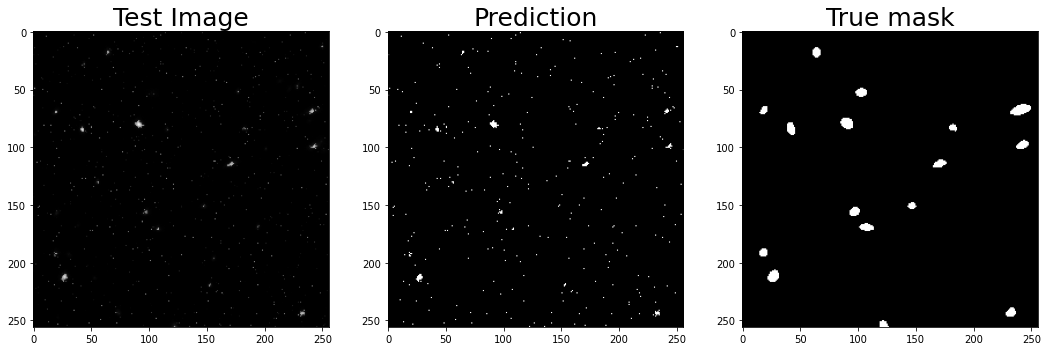

In [ ]:
fontdict_ = {'fontsize': 25,
             'fontweight':'light'}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,10))
img  = image_dataset3[10]
pred = predictions3[10]
true = mask_dataset4[10]
pred[pred > 0] = 1
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Test Image', fontdict = fontdict_)
ax2.imshow(pred, cmap = 'gray')
ax2.set_title('Prediction', fontdict = fontdict_)
ax3.imshow(true, cmap = 'gray')
ax3.set_title('True mask', fontdict = fontdict_)
plt.savefig('kmeans_pred3.pdf')
plt.show();

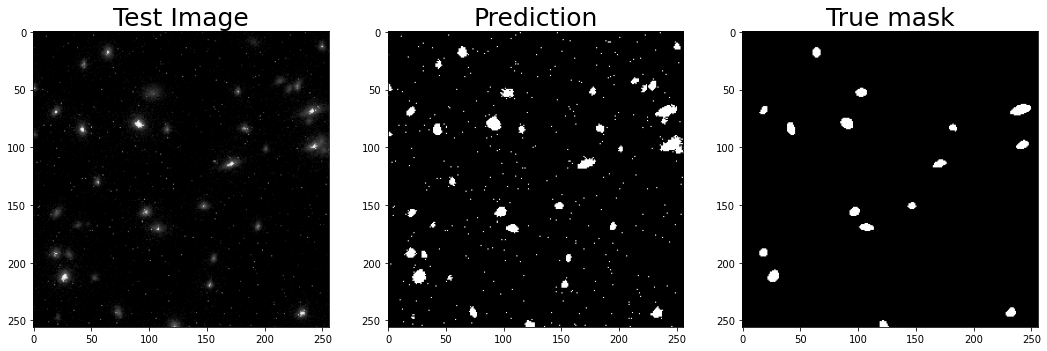

In [17]:
fontdict_ = {'fontsize': 25,
             'fontweight':'light'}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,10))
img  = image_dataset4[10]
pred = predictions4[10]
true = mask_dataset4[10]
pred[pred > 0] = 1
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Test Image', fontdict = fontdict_)
ax2.imshow(pred, cmap = 'gray')
ax2.set_title('Prediction', fontdict = fontdict_)
ax3.imshow(true, cmap = 'gray')
ax3.set_title('True mask', fontdict = fontdict_)
plt.savefig('kmeans_pred4.png')
plt.show();